Training notebook. Save models for use in `founder-rank.ipynb`. Simple gradient-based quadratic classification model to compute $W$. 

In [1]:
import sys
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
from pathlib import Path
import pickle

sys.path.append("..")

from src.models.trainer import create_model_and_trainer
from src.config.config import cfg
from src.viz.model_viz import plot_model_performance, plot_feature_importance, plot_ranked_feature_importance, plot_sample_predictions, display_final_metrics, plot_top_feature_interactions
from src.data.preprocessing import load_and_preprocess_data
from src.models.trainer import create_model_and_trainer
from src.viz.model_viz import (
    plot_model_performance, 
    plot_ranked_feature_importance, 
    plot_feature_importance,
    plot_sample_predictions,
    display_final_metrics,
    plot_top_feature_interactions
)

np.set_printoptions(precision=2, suppress=True, linewidth=120)


### Hyperparameters

In [2]:
# model_dir = Path("../models")
# with open(model_dir / "founder_rank_best.pkl", 'rb') as f:
#     model_data = pickle.load(f)

# print("Hyperparameters used:")
# for key, value in model_data['hyperparameters'].items():
#     print(f"{key}: {value}")

In [3]:
# Define hyperparameters
hyp = {
    "data_paths": [
        "../data/encoded/S21_encoded_with_outcomes.csv",
        "../data/encoded/W21_encoded_with_outcomes.csv",
        "../data/encoded/S17_encoded_with_outcomes.csv",
        "../data/encoded/W17_encoded_with_outcomes.csv",
        "../data/encoded/top_companies_encoded_with_outcomes.csv"
    ],
    "synthetic_data_path": '../data/synth/encoded_founders_composites.csv',
    "test_size": 0.15,  
    "val_size": 0.15,   
    "random_state": 42,
    "batch_size": 64,     
    "lr": 0.0005,         
    "weight_decay": 1.8e-3,  
    "epochs": 300,       
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "exclude_columns": ["success", "exit_value", "funding_amount", "batch"],
    "target_column": "success",
    
    # Regularization parameters
    "diag_penalty": 0.0002,    
    "l1_penalty": 0.0004,      
    "top_k_penalty": 0.0005,   
    "top_k": 15,               
    "dropout": 0.15,           
    
    # Training parameters
    "log_every": 10,
    "early_stopping_patience": 250,
    
    # Evaluation metrics parameters
    "k_values": [10, 25, 50],  # K values for NDCG and Precision
    "early_stopping_metric": "ndcg@10" 
}

### Training

In [4]:

tensors, feature_names, scaler = load_and_preprocess_data(hyp)

X_train_tensor, y_train_tensor, is_synthetic_train_tensor = tensors['train']
X_val_tensor, y_val_tensor = tensors['val']
X_test_tensor, y_test_tensor = tensors['test']

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, is_synthetic_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=hyp["batch_size"], shuffle=True)

input_dim = X_train_tensor.shape[1]
pos_weight = (y_train_tensor == 0).sum() / (y_train_tensor == 1).sum()
model, trainer = create_model_and_trainer(input_dim, hyp, pos_weight=pos_weight)

W_init = trainer.train(train_loader,  X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor)

W_final = model.get_W().detach().cpu().numpy()

predictions = trainer.predict(X_train_tensor, X_val_tensor, X_test_tensor)
train_probs, train_preds = predictions['train']
val_probs, val_preds = predictions['val'] 
test_probs, test_preds = predictions['test']


Data Split Summary:
Real data: 1386 samples
Synthetic data: 5000 samples

Train set: 6001 samples (1001 real, 5000 synthetic)
Val set: 177 samples (all real)
Test set: 208 samples (all real)

Class distribution:
Train set - Real: 365/1001 positive
Train set - Synthetic: 277/5000 positive
Val set: 64/177 positive
Test set: 76/208 positive
Epoch Train Loss  Train AUC Train NDCG  Tr N@10  Tr P@10  Tr N@25  Tr P@25  Tr N@50  Tr P@50 Train Acc   Val Loss    Val AUC   Val NDCG Val N@10 Val P@10 Val N@25 Val P@25 Val N@50 Val P@50   Val Acc  Test Loss   Test AUC  Test NDCG Tst N@10 Tst P@10 Tst N@25 Tst P@25 Tst N@50 Tst P@50  Test Acc
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Using k_values: [10, 25, 50]
    0   215.2064     0.5000     0.6897   0.1070   0.4000

### Model Performance

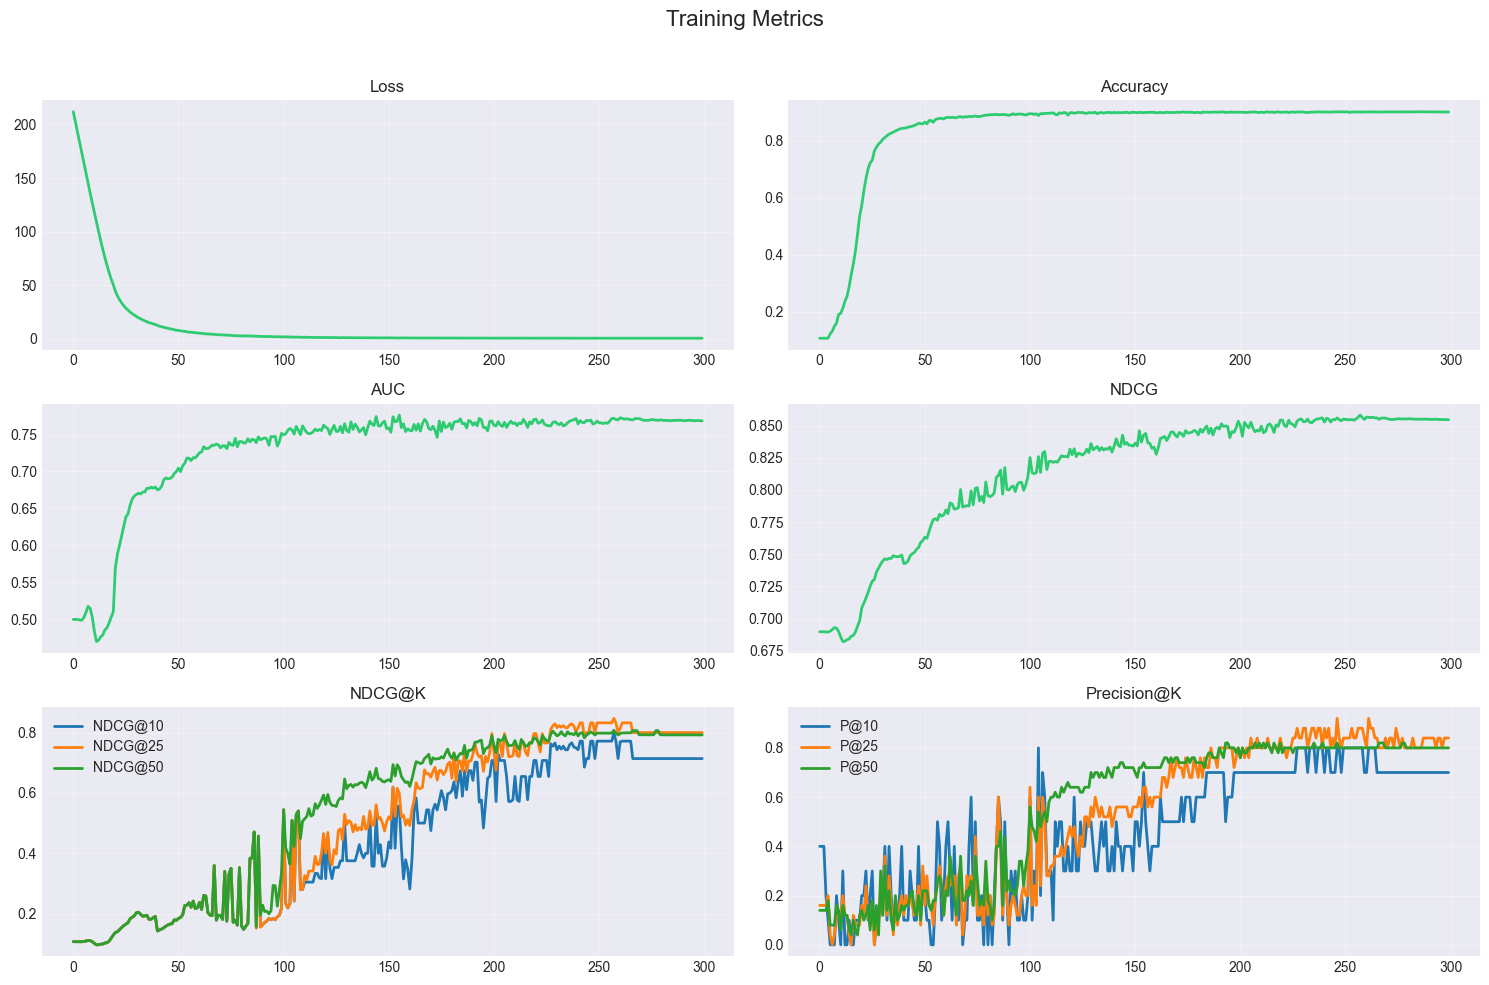

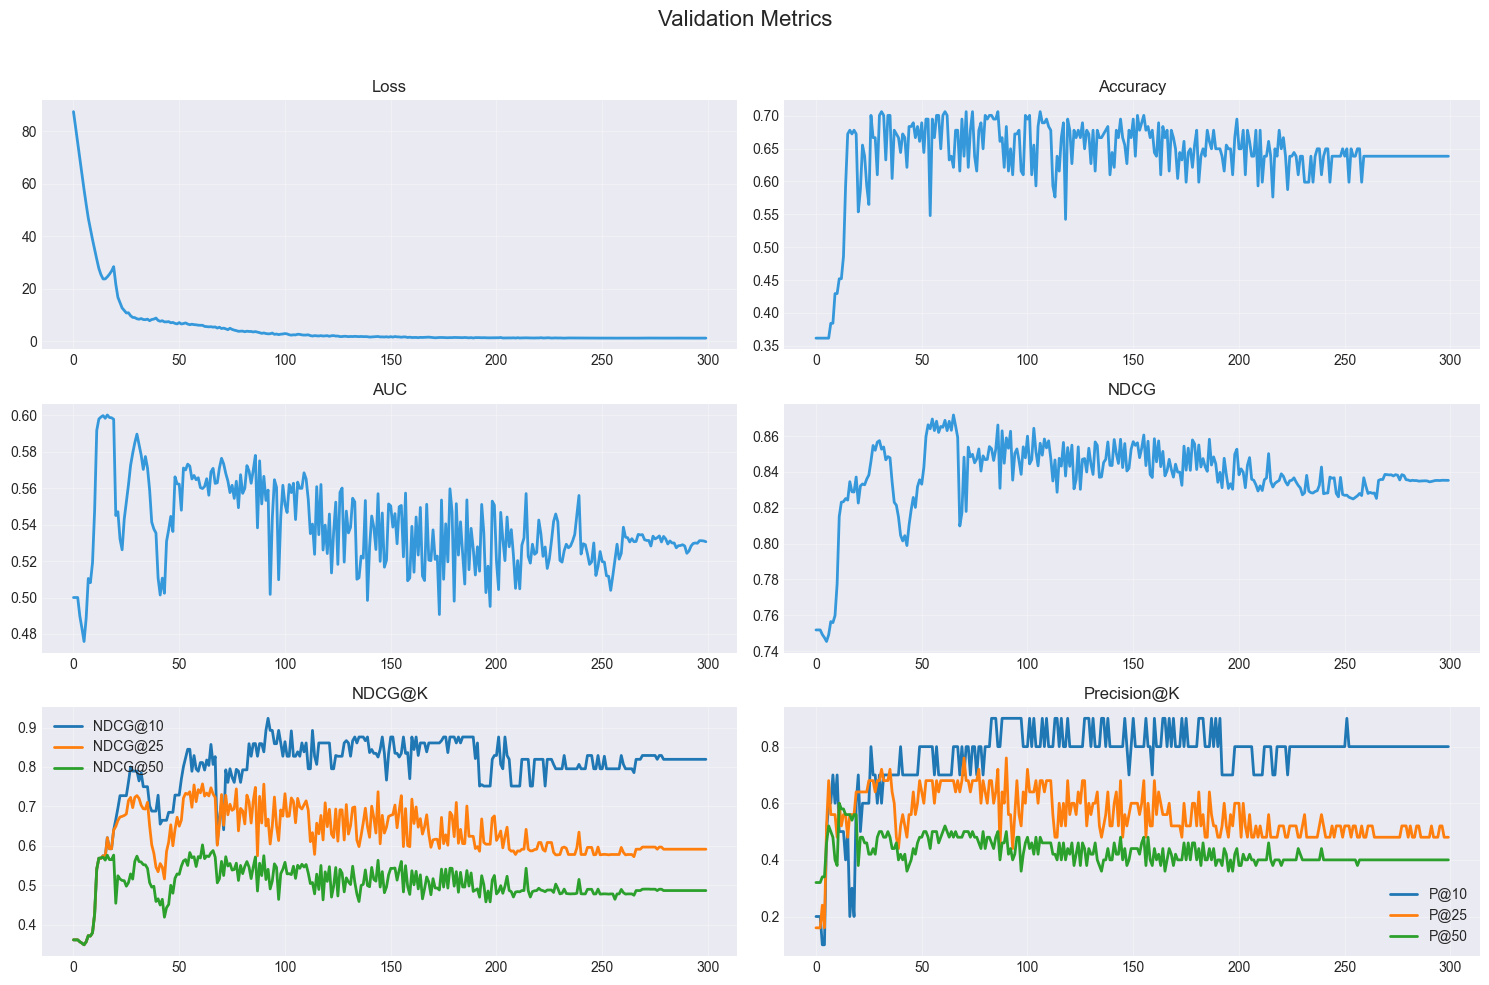

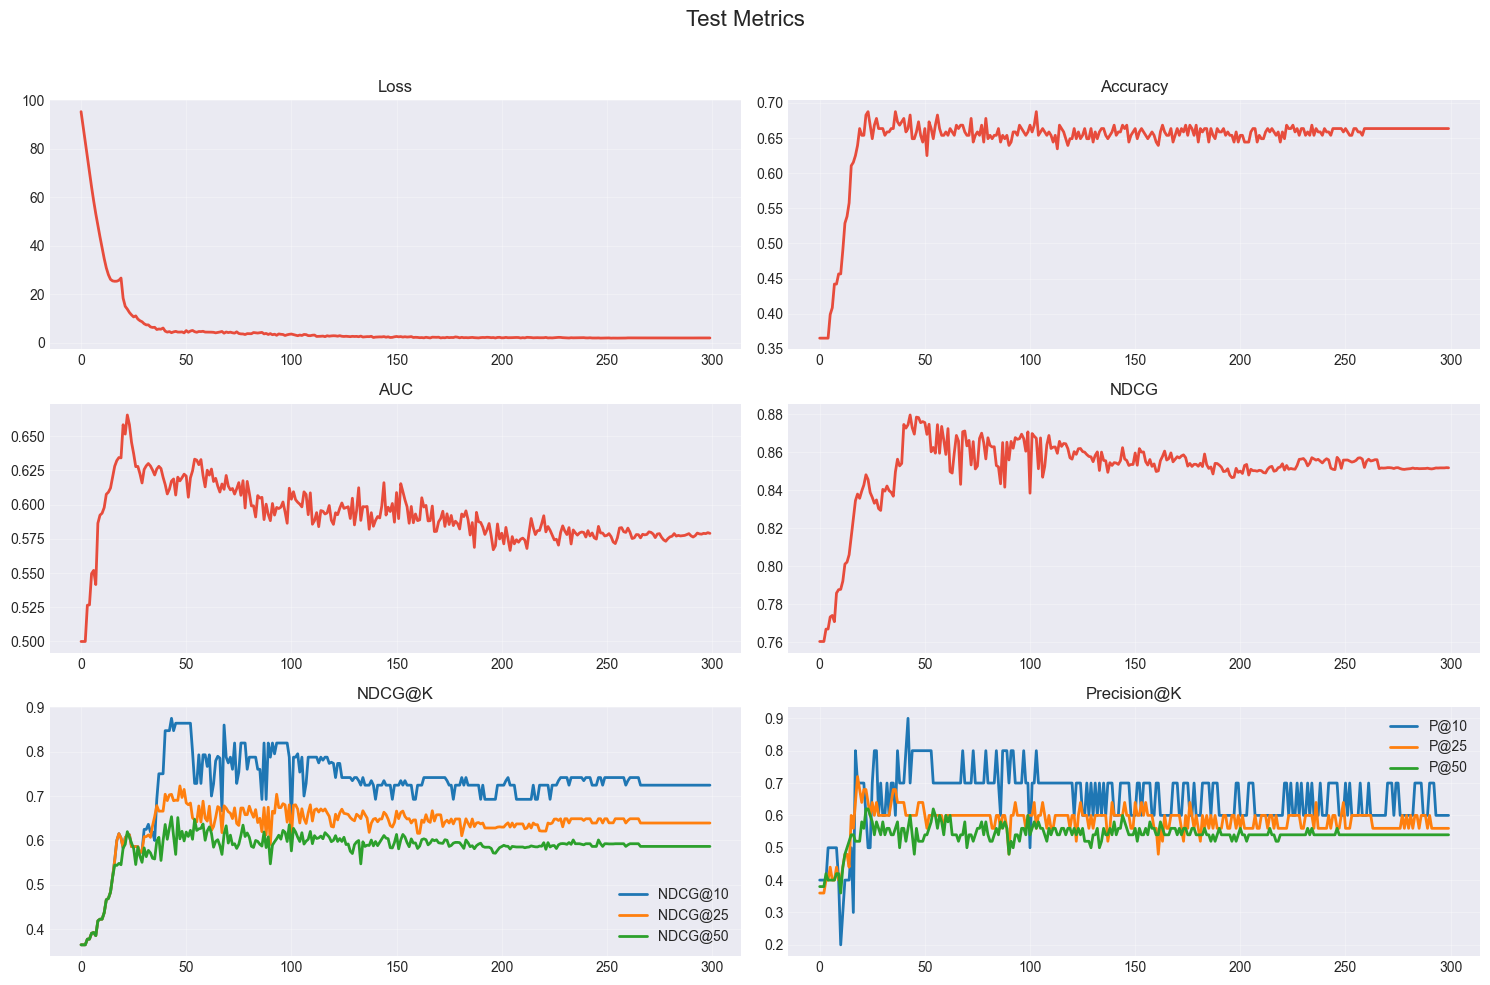

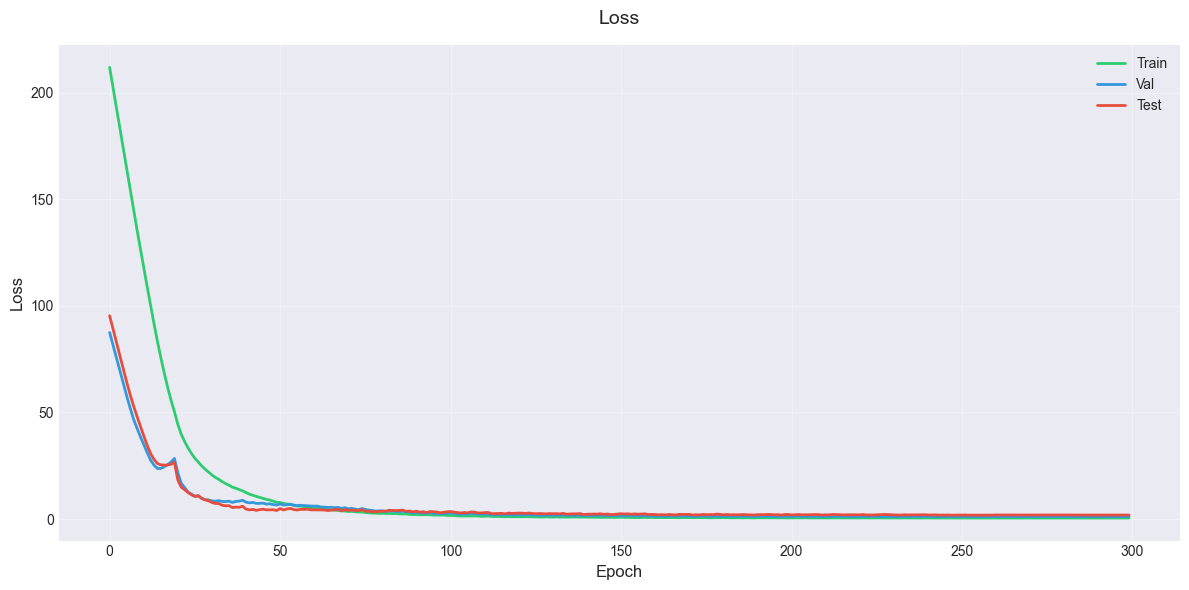

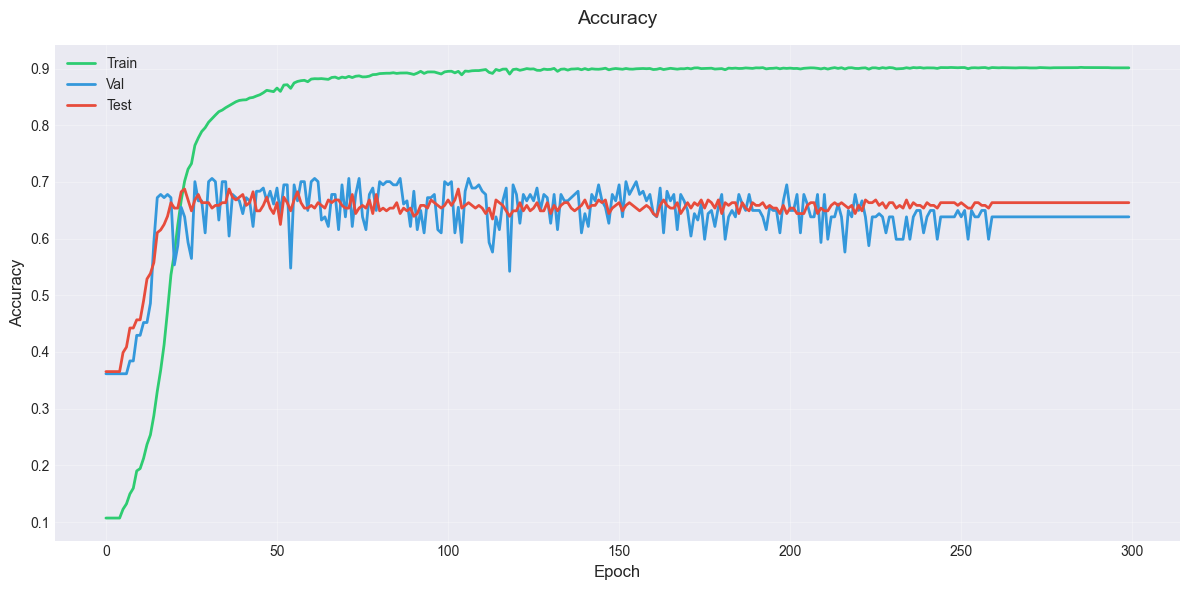

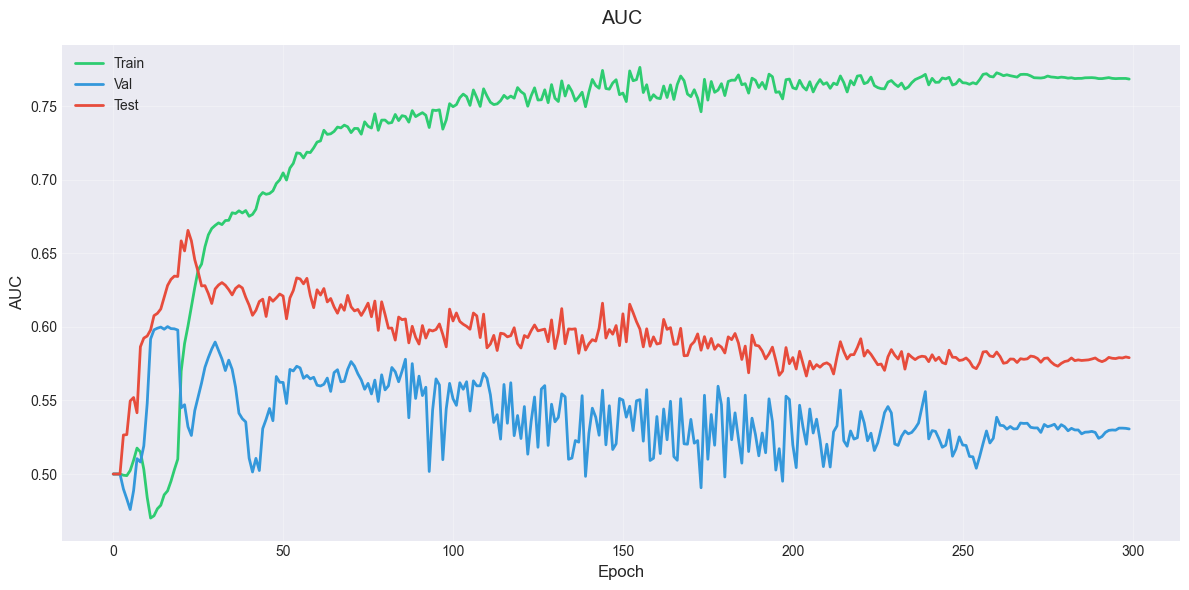

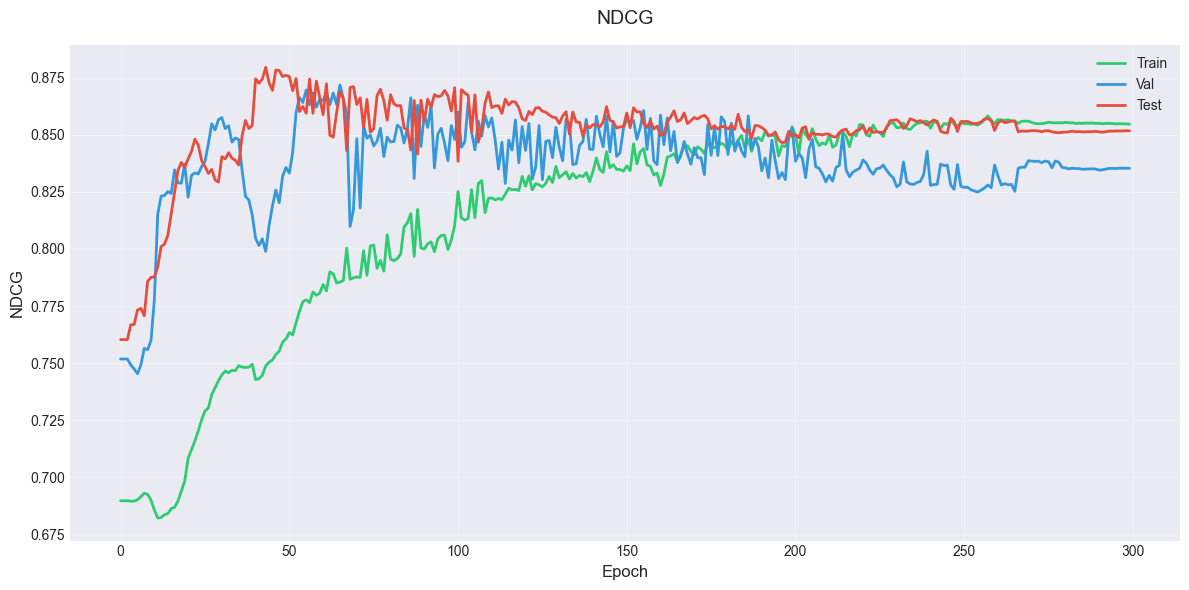

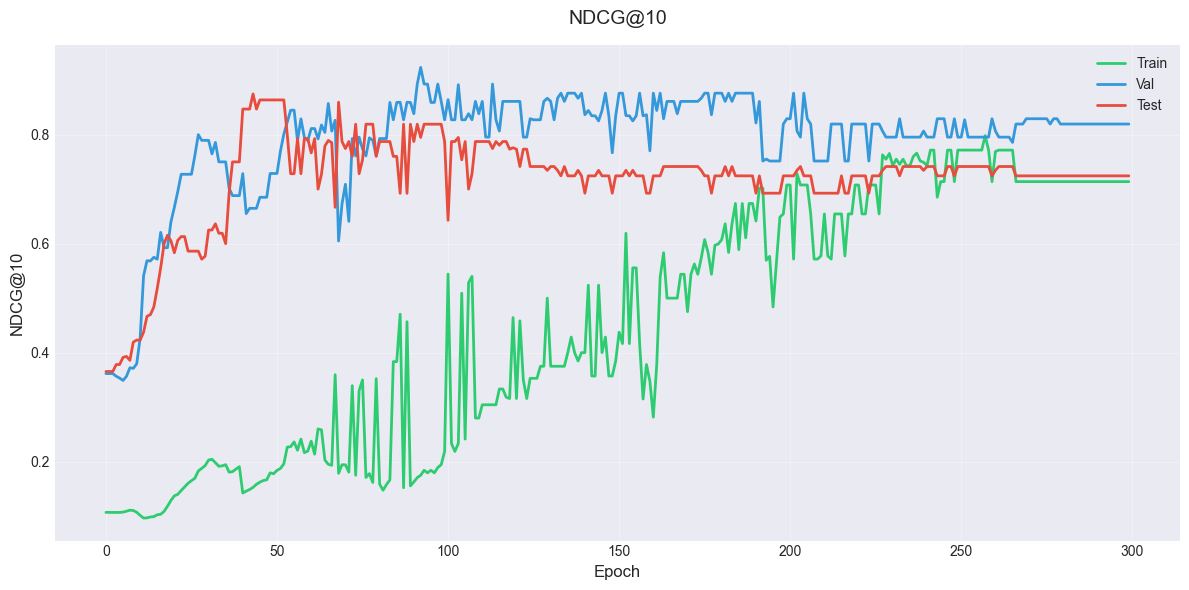

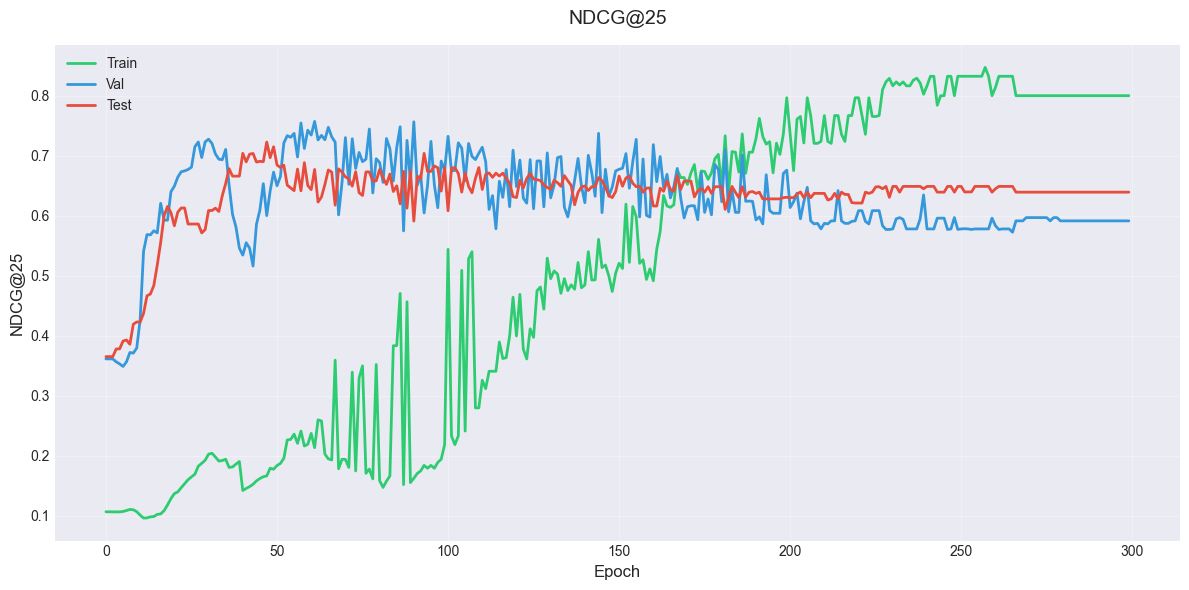

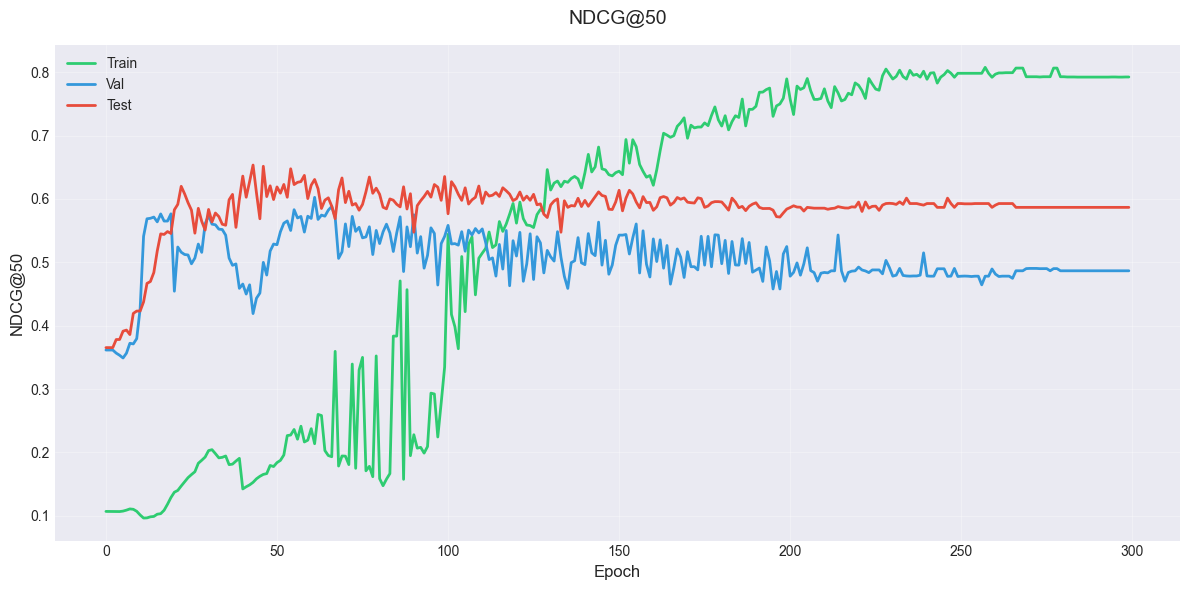

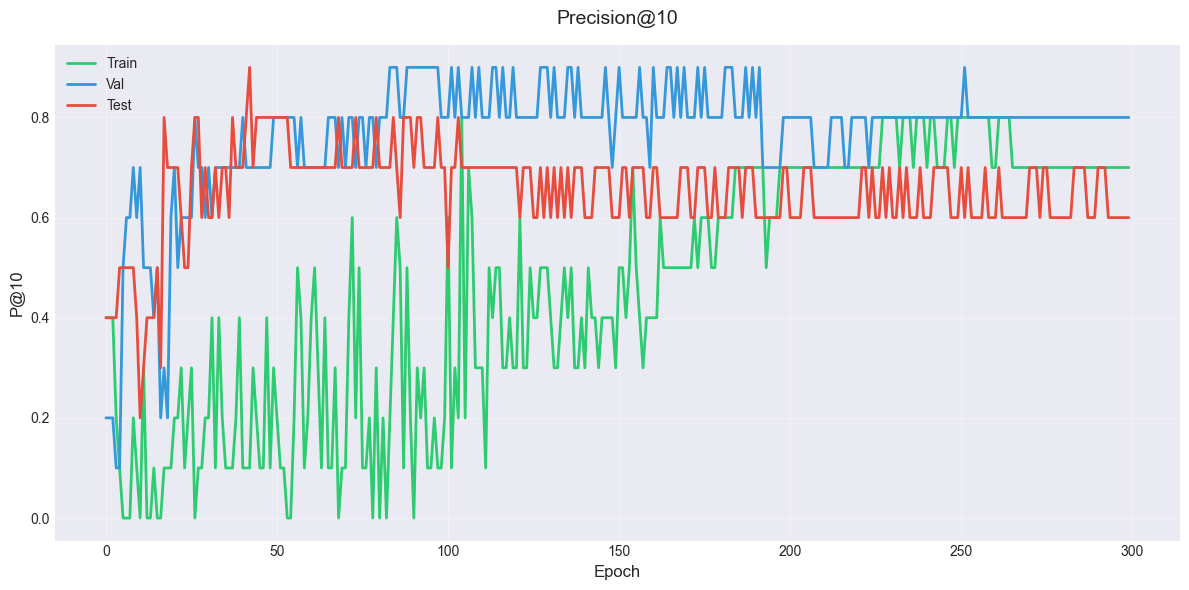

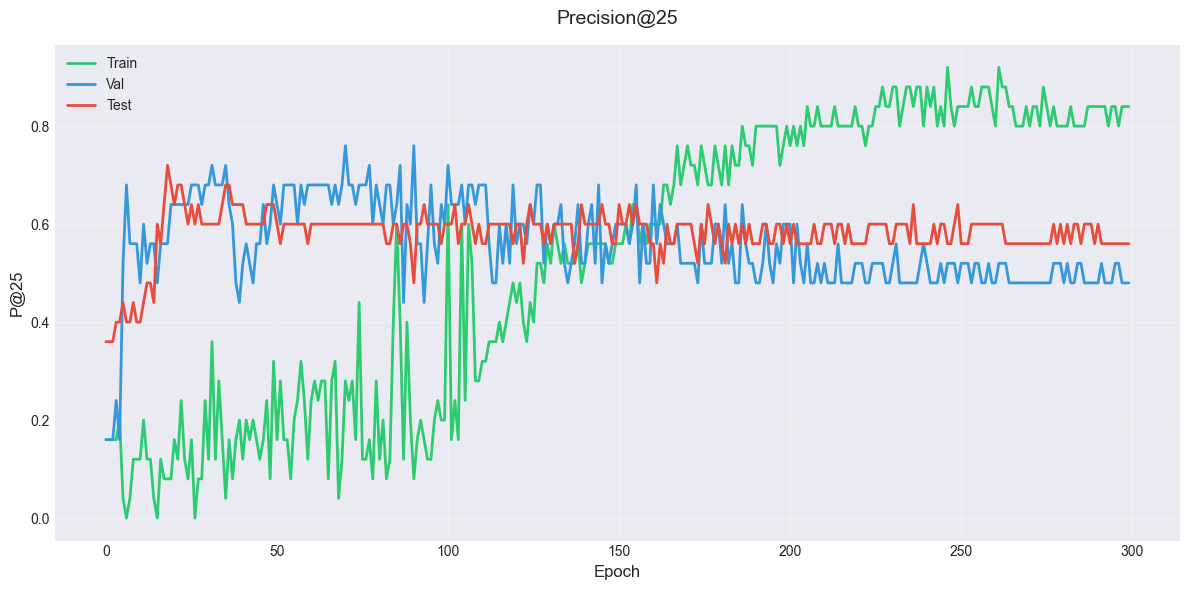

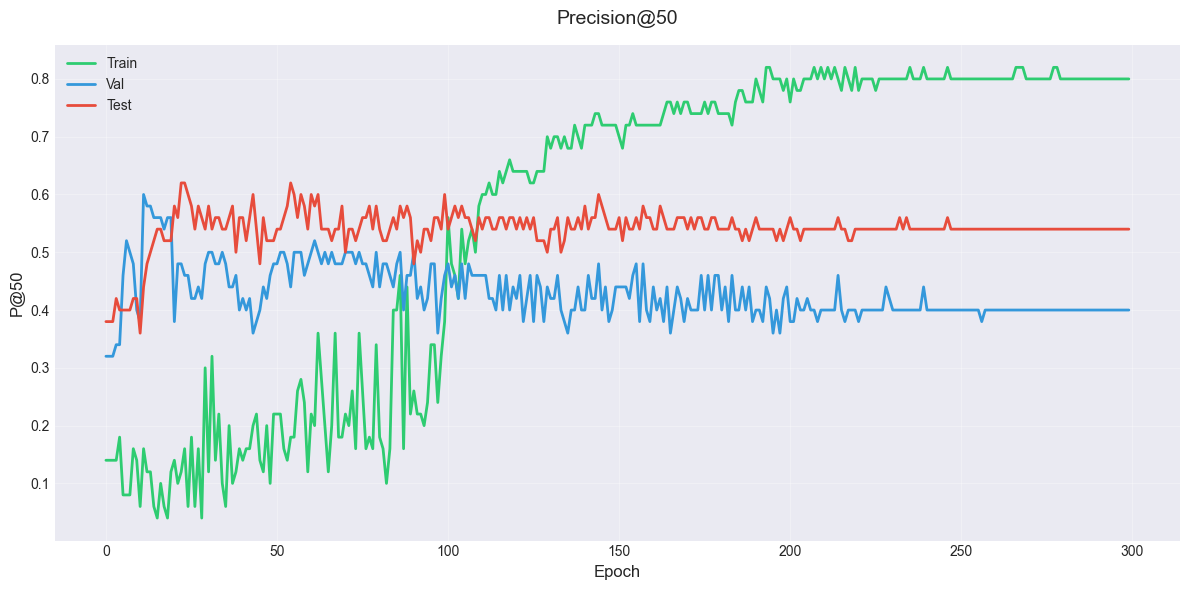

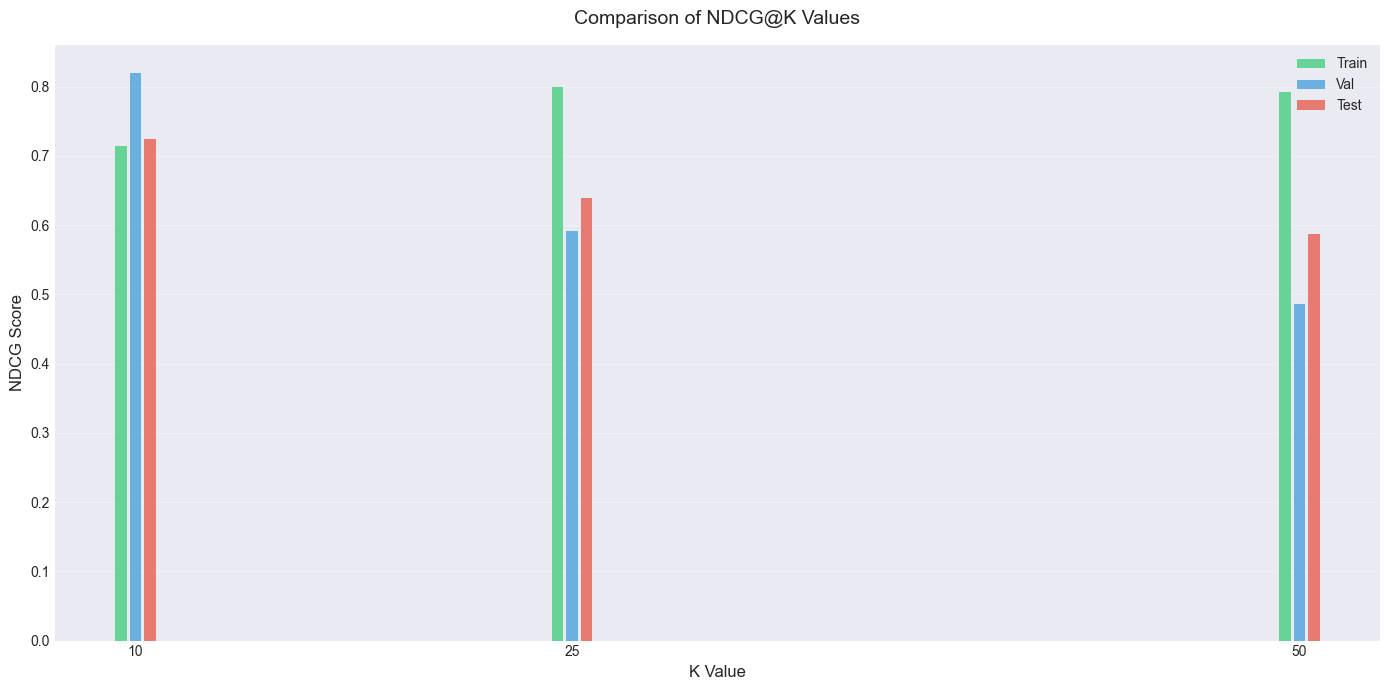

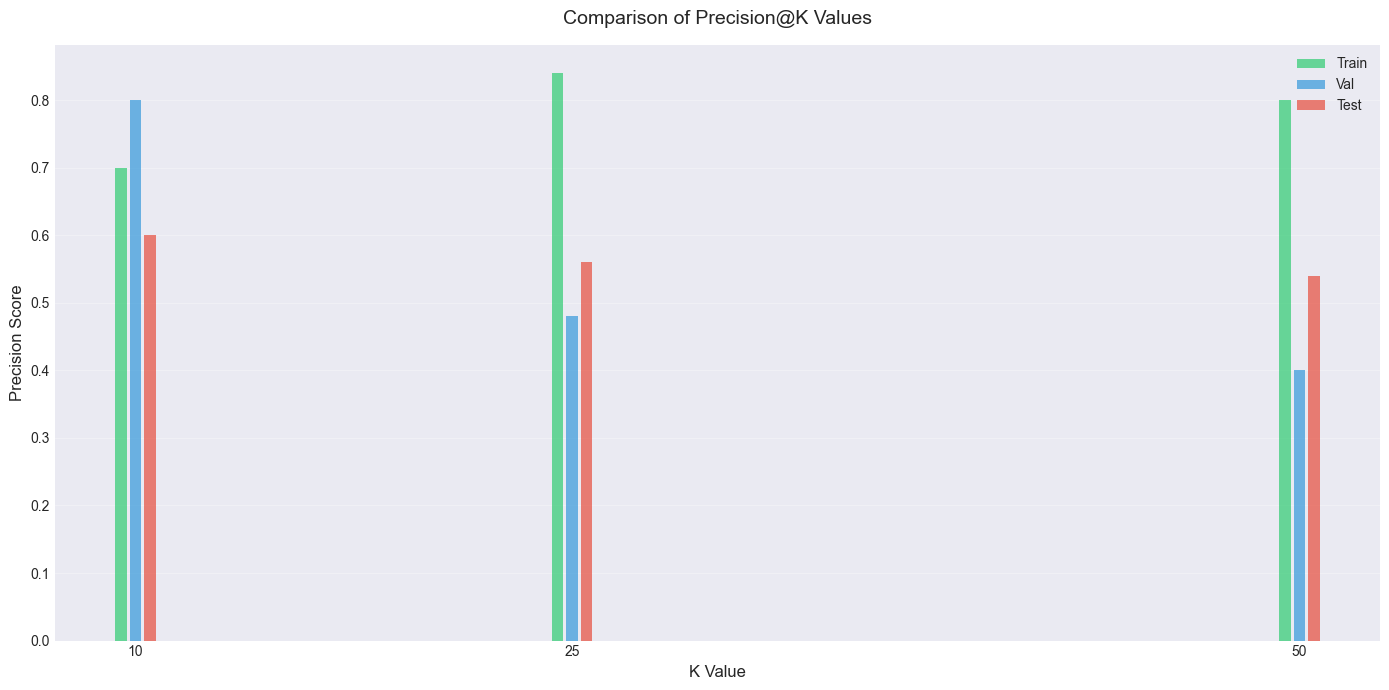

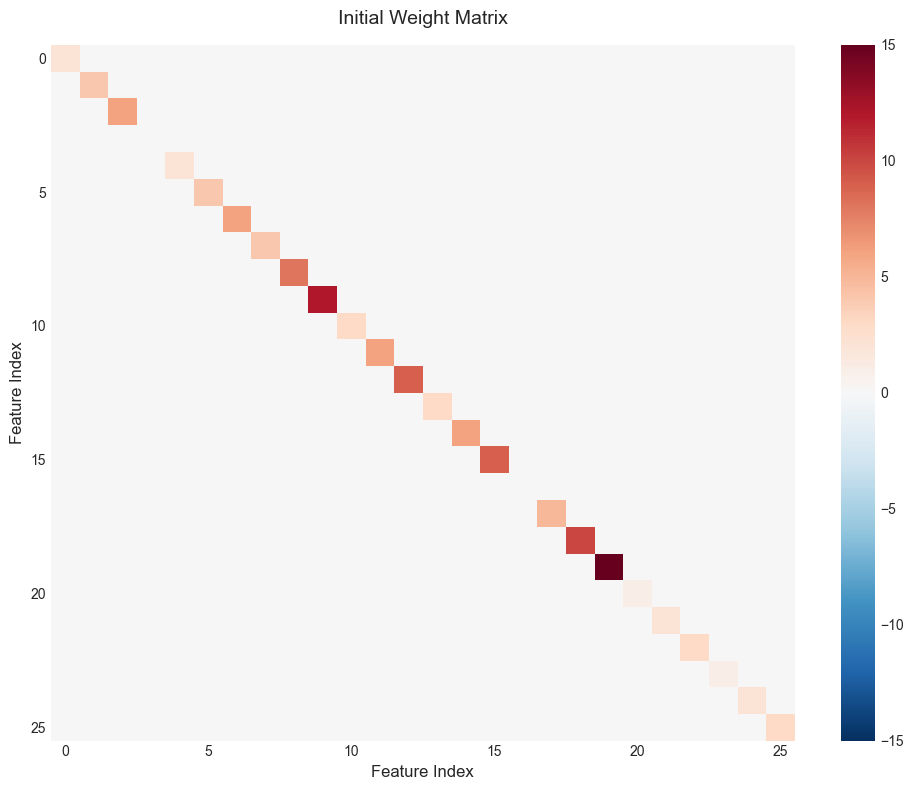

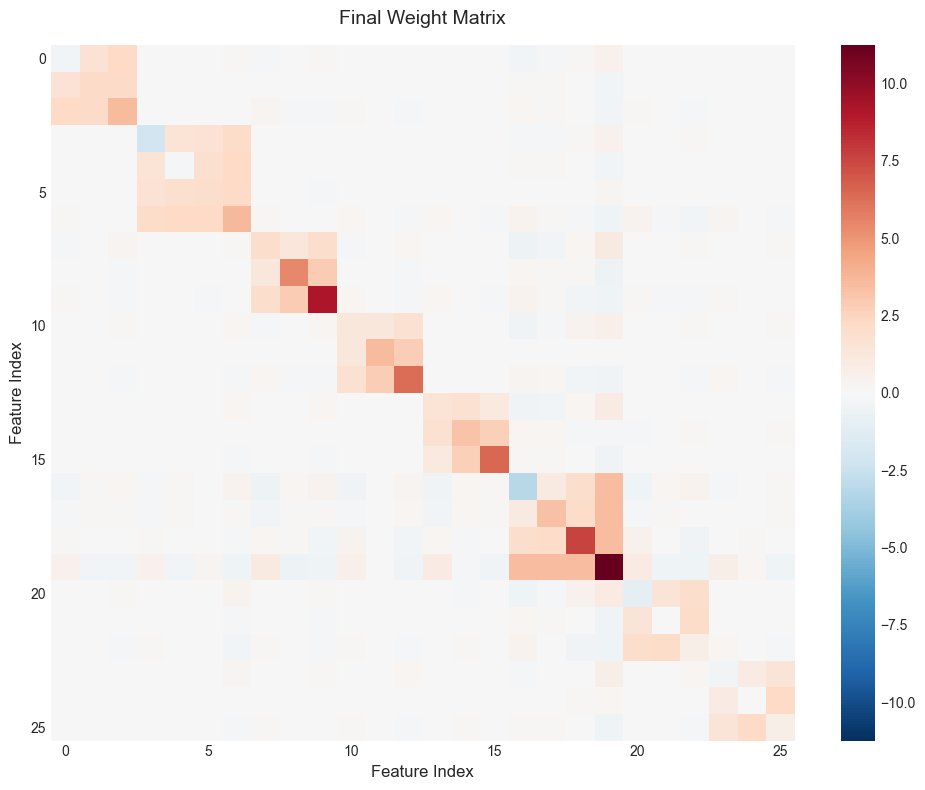

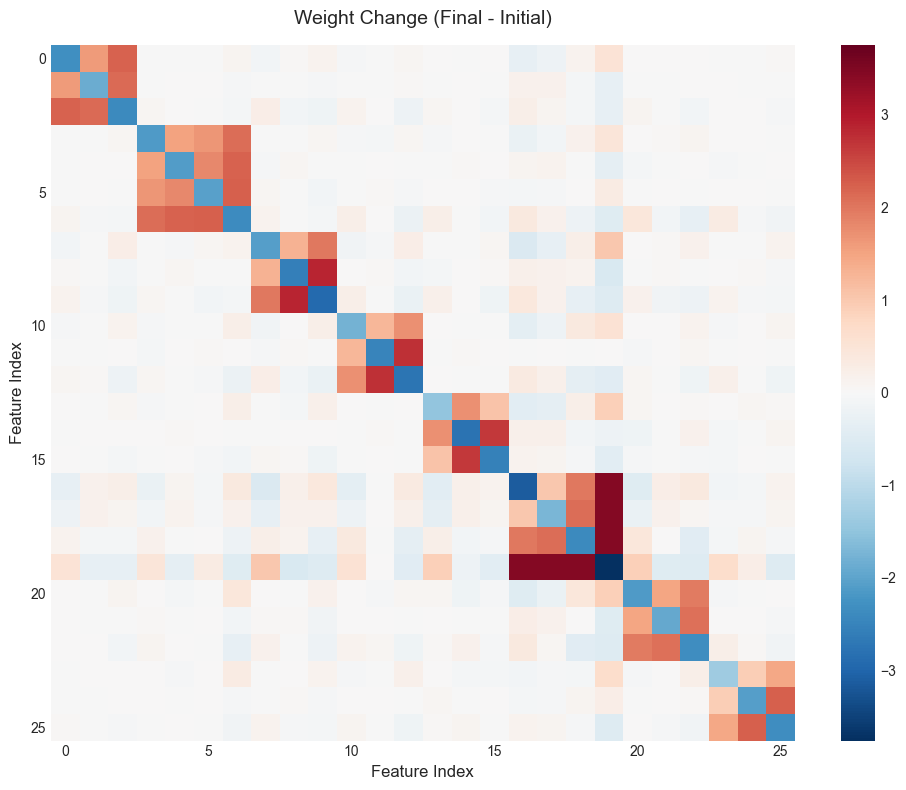

In [5]:
plot_model_performance(trainer, W_init)

### Features

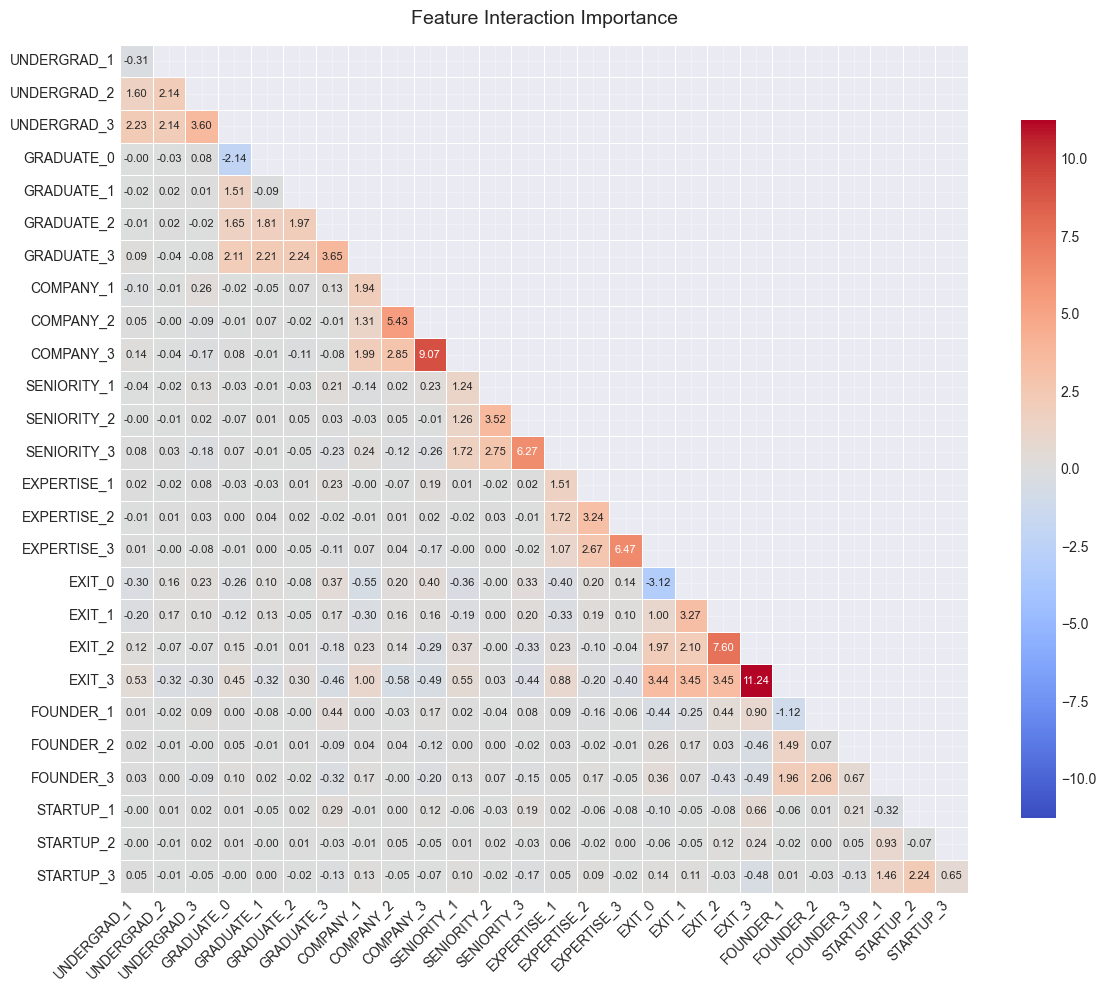

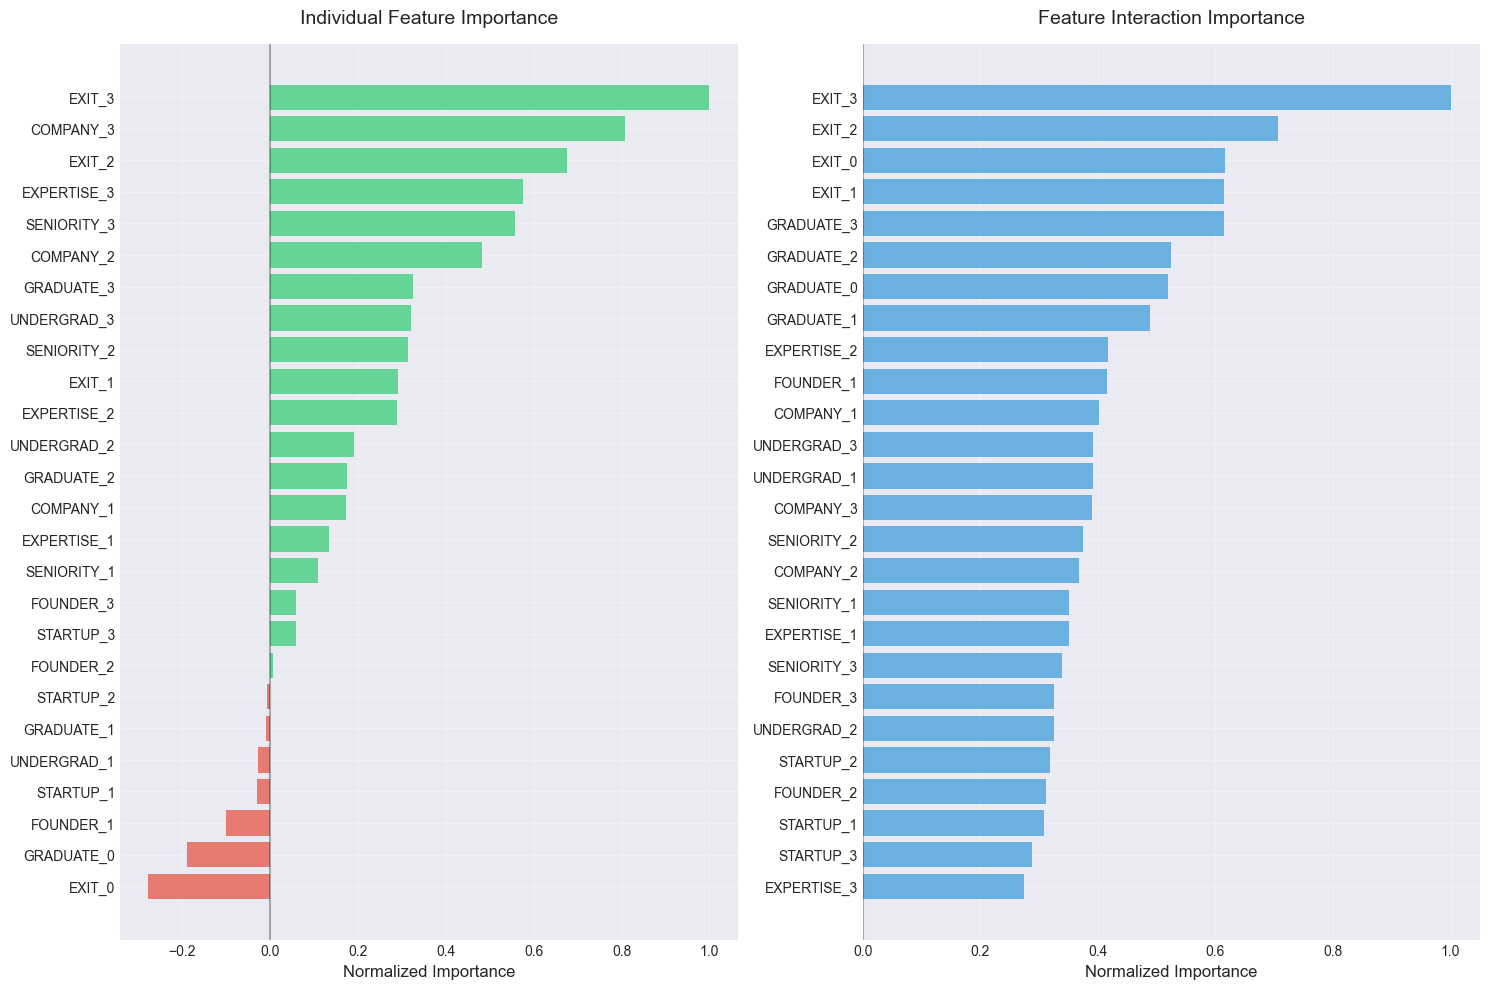

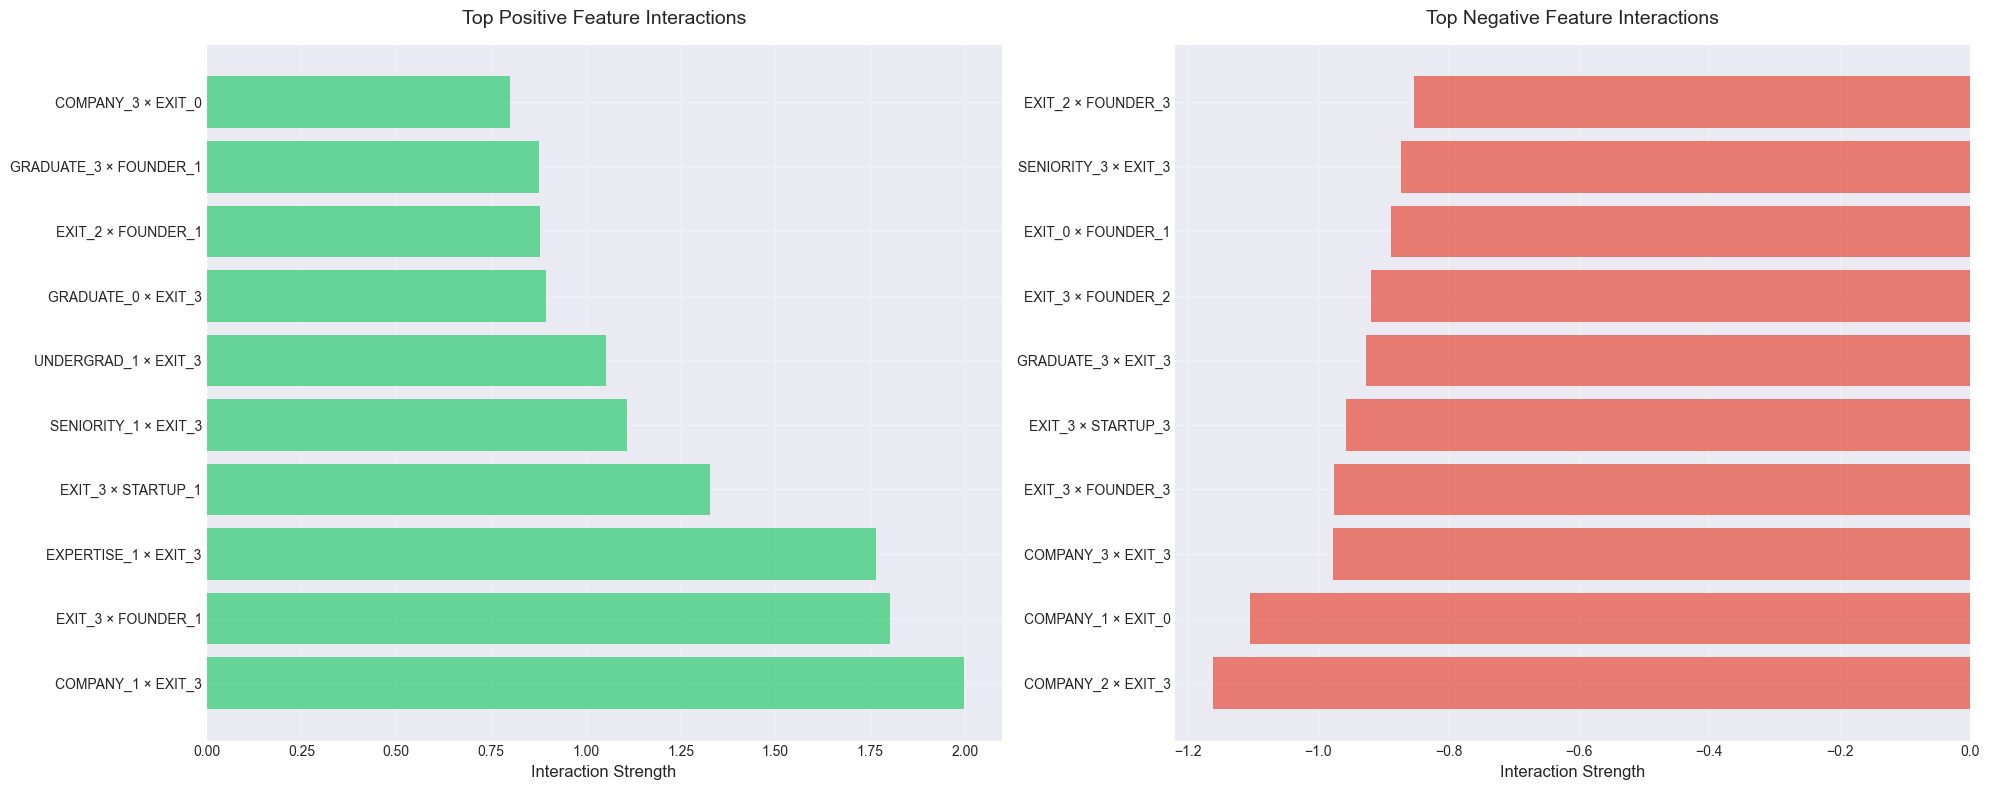

In [6]:
plot_feature_importance(W_final, feature_names)
plot_ranked_feature_importance(W_final, feature_names)
plot_top_feature_interactions(W_final, feature_names)

### Samples

Note: deliberately samples some TP, TN, FP, FN for ref. 

/Users/Viresh/Desktop/Spring 2025/Angel Network/founder-rank/notebooks/../src/viz/model_viz.py:404: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


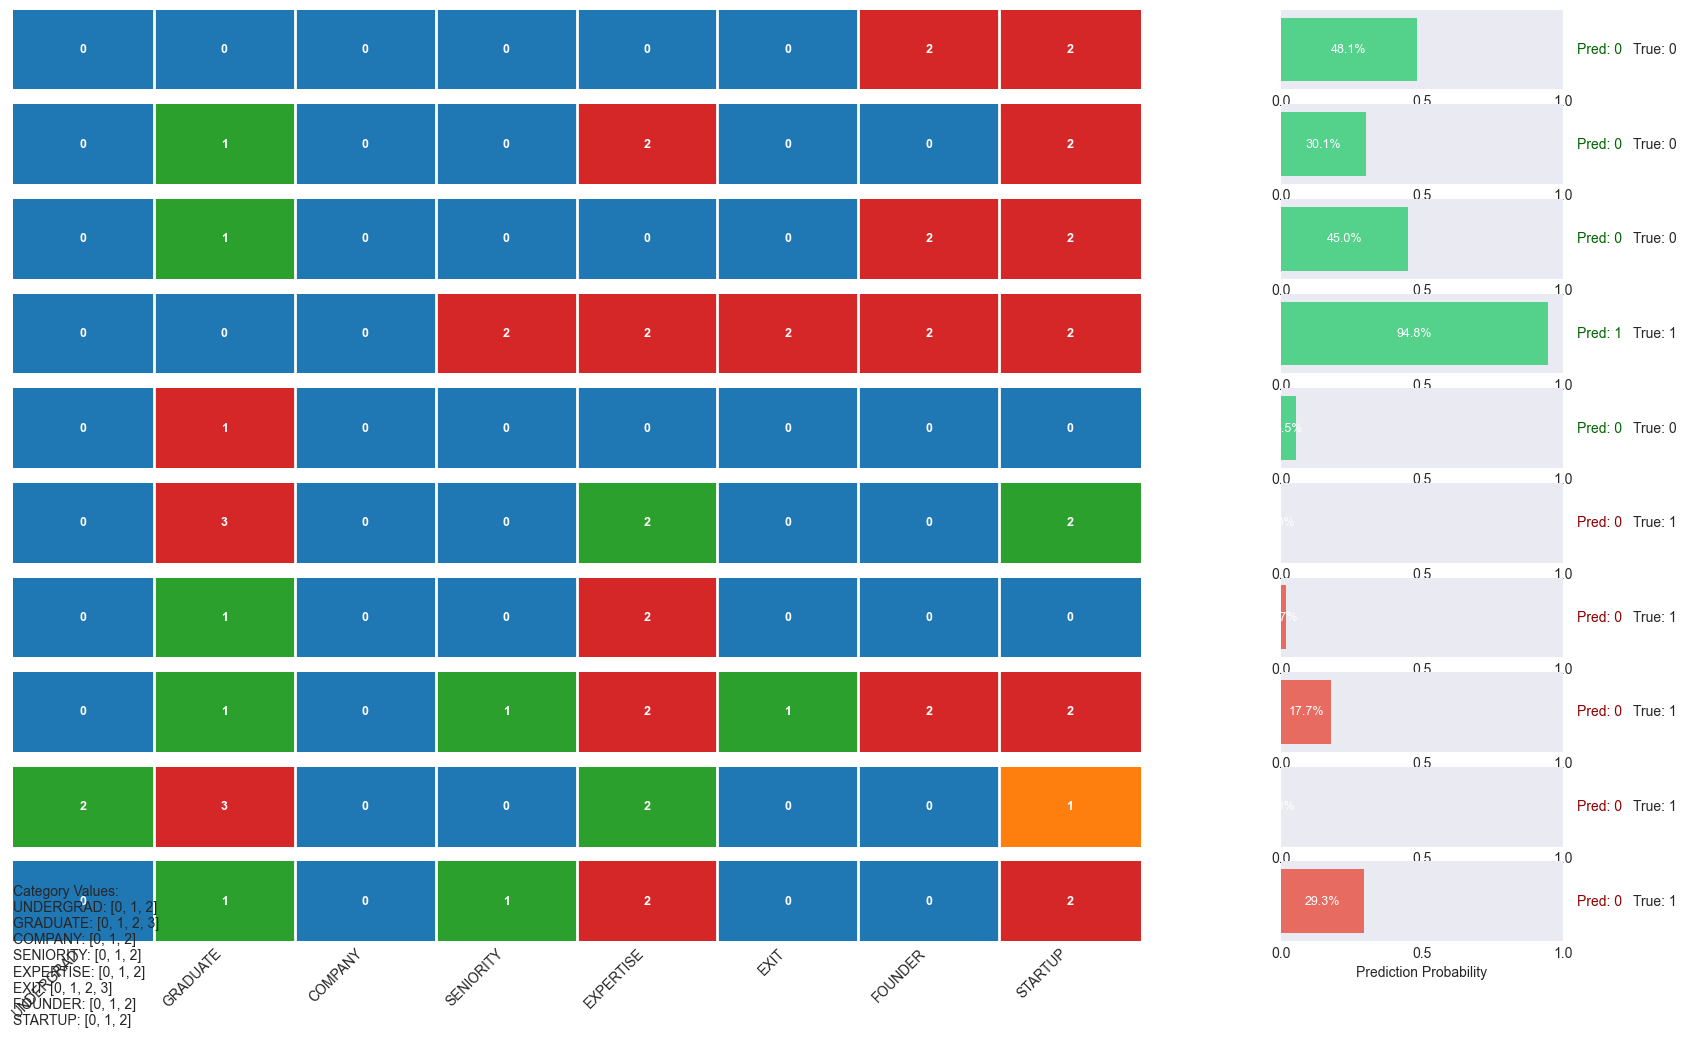

In [7]:
plot_sample_predictions(model, X_test_tensor.numpy(), y_test_tensor.numpy(), cfg.MATRIX, scaler, n_samples=10, device=hyp['device'])

### Metrics

Note: NDCG is eval metric. 

<Figure size 1200x600 with 0 Axes>

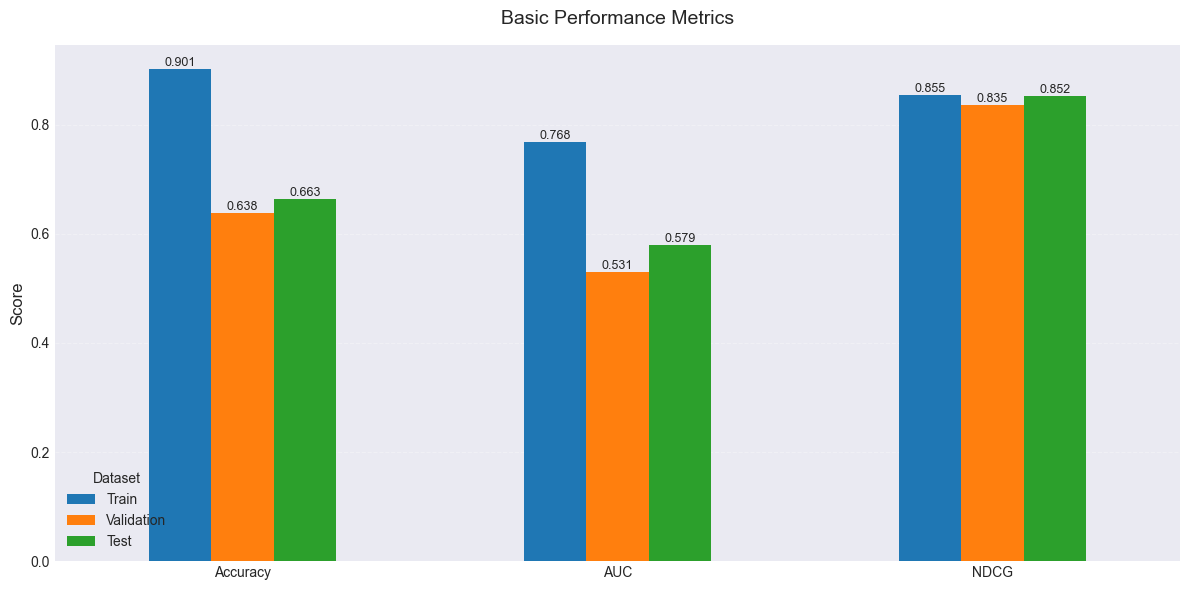

<Figure size 1200x600 with 0 Axes>

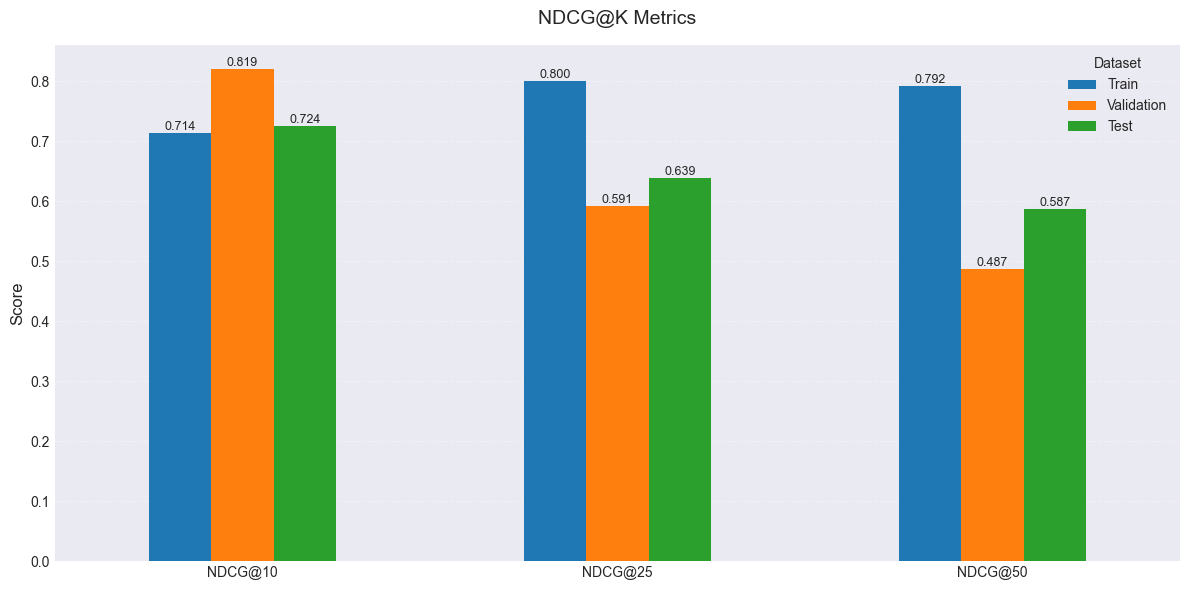

<Figure size 1200x600 with 0 Axes>

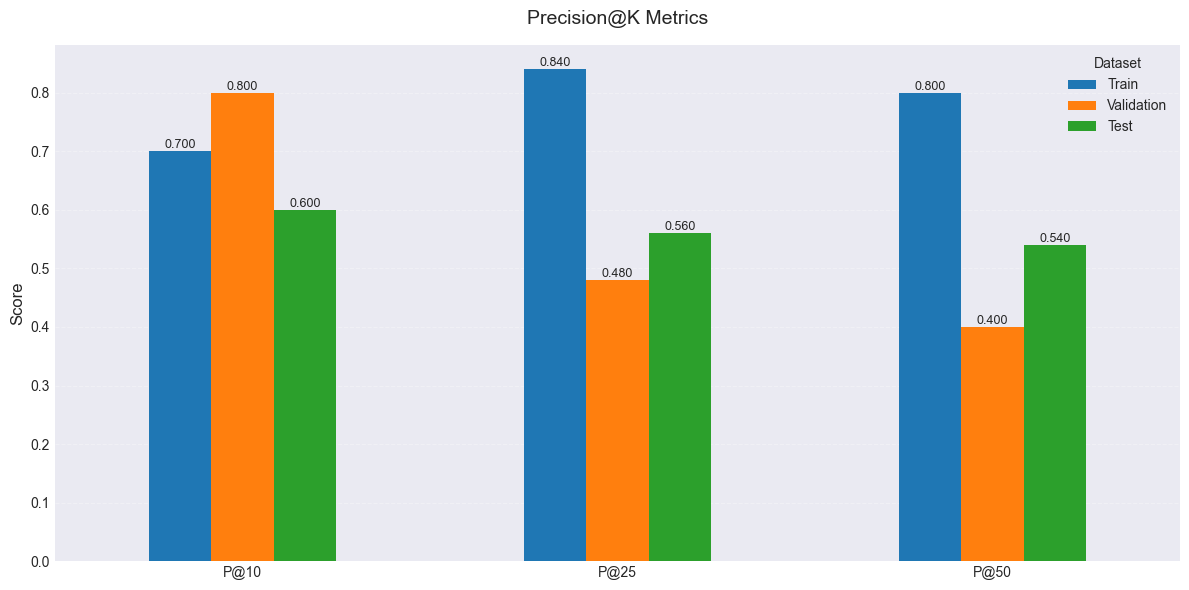


Final Metrics Summary:
           Train  Validation    Test
NDCG      0.8547      0.8353  0.8517
Accuracy  0.9013      0.6384  0.6635
AUC       0.7684      0.5306  0.5790
NDCG@10   0.7138      0.8194  0.7244
P@10      0.7000      0.8000  0.6000
NDCG@25   0.8000      0.5915  0.6393
P@25      0.8400      0.4800  0.5600
NDCG@50   0.7923      0.4866  0.5866
P@50      0.8000      0.4000  0.5400

TRAIN SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      5359
         1.0       0.66      0.16      0.26       642

    accuracy                           0.90      6001
   macro avg       0.78      0.57      0.60      6001
weighted avg       0.88      0.90      0.87      6001


VALIDATION SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.66      0.89      0.76       113
         1.0       0.50      0.19      0.27        64

    accuracy                           0.64 

In [8]:

display_final_metrics(trainer)

print("\n" + "="*80)
print("TRAIN SET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_train_tensor.cpu().numpy(), train_preds, zero_division=0))

print("\n" + "="*80)
print("VALIDATION SET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_val_tensor.cpu().numpy(), val_preds, zero_division=0))

print("\n" + "="*80)
print("TEST SET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test_tensor.cpu().numpy(), test_preds, zero_division=0))

In [9]:
# model_dir = Path("../models")
# model_dir.mkdir(exist_ok=True)

# model_data = {
#     'model_state_dict': model.state_dict(),
#     'W_init': W_init,
#     'W_final': model.get_W().detach().cpu().numpy(),
#     'feature_names': feature_names,
#     'scaler_state': scaler.__getstate__(),
#     'hyperparameters': hyp 
# }

# with open(model_dir / "founder_rank.pkl", 'wb') as f:
#     pickle.dump(model_data, f)
